In [1]:
%matplotlib inline
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def voss(nrows, ncols=16, meanwindow=2, rs=None):
    # code for this function adapted from code by Allen Downey (CC-BY license):
    # https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb
    """
    Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    meanwindow: window size for rolling mean
    rs: random state
    
    returns: NumPy array
    """
    if rs is None:
        rs = np.random.RandomState()
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = rs.random_sample(ncols)
    array[:, 0] = rs.random_sample(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = rs.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = rs.randint(nrows, size=n)
    array[rows, cols] = rs.random_sample(n)
    
    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = pd.Series.rolling(df.sum(axis=1), meanwindow, min_periods=0).mean()
    # total = df.sum(axis=1)
    
    return total.values



c = np.sin(np.arange(0, np.pi, 0.066))

meanwindow=12


In [3]:
resp_buffer = 1500
baseline = 200
datasamples = 1500
min_rt = 300
max_rt = 1500
minlat = 60  # 25
maxlat = 100  # 75
stim_components = 3 
resp_components = 3
stim_samples = []
resp_samples = []
rts = []
n = 128
rs = np.random.RandomState(seed=999)
for i in range(n):
    eeg = voss(resp_buffer+datasamples+2*baseline+2*meanwindow,
               meanwindow=meanwindow, rs=rs)[meanwindow:-meanwindow]
    #eeg -= np.mean(eeg[:baseline])
    eeg -= np.mean(eeg)
    stim_onset = resp_buffer + baseline
    rt = rs.randint(min_rt, max_rt+1, 1)[0]
    rts.append(rt)
    resp_onset = resp_buffer + baseline + rt
    stim_latencies = rs.randint(minlat, maxlat+1, stim_components)
    resp_latencies = rs.randint(minlat, maxlat+1, resp_components)
    for i in range(len(stim_latencies)):
        if i%2 == 0:
            eeg[(stim_onset+np.sum(stim_latencies[:(i+1)])):
                (stim_onset+np.sum(stim_latencies[:(i+1)])+len(c))] -= c
        else:
            eeg[(stim_onset+np.sum(stim_latencies[:(i+1)])):
                (stim_onset+np.sum(stim_latencies[:(i+1)])+len(c))] += c
    for i in range(len(stim_latencies)):
        if i%2 == 0:
            eeg[(resp_onset - np.sum(resp_latencies[:(i+1)])):
                (resp_onset - np.sum(resp_latencies[:(i+1)])+len(c))] -= c
        else:
            eeg[(resp_onset - np.sum(resp_latencies[:(i+1)])):
                (resp_onset - np.sum(resp_latencies[:(i+1)])+len(c))] += c  
    # stim_samples.append(eeg.copy())
    stim_samples.append(eeg[(stim_onset-baseline):(stim_onset+datasamples)])
    #resp_samples.append(eeg[(datasamples+baseline-rt):(2*baseline+rt)])
    # print rt, baseline+rt-datasamples, 2*baseline+rt
    resp_samples.append(eeg[(resp_onset-datasamples):(resp_onset+baseline)])


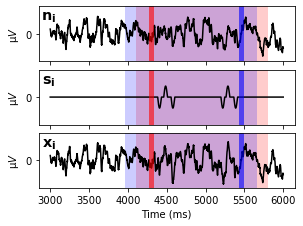

In [4]:
rs = np.random.RandomState(seed=999)
resp_buffer = 1100
noise = voss(resp_buffer+datasamples+2*baseline+2*meanwindow,
               meanwindow=meanwindow, rs=rs)[meanwindow:-meanwindow]
noise -= np.mean(noise)
stim_onset = resp_buffer + baseline
rt = rs.randint(min_rt, max_rt+1, 1)[0]
resp_onset = resp_buffer + baseline + rt
stim_latencies = rs.randint(minlat, maxlat+1, stim_components)
resp_latencies = rs.randint(minlat, maxlat+1, resp_components)



ymax = 2.5
fig, axs = plt.subplots(3,1, sharex=True, sharey=True, figsize=(4,3))
axs[0].plot(noise, 'k-')
axs[0].plot([stim_onset, stim_onset], [-ymax, ymax], 'r-', lw=5, alpha=0.6)
axs[0].plot([resp_onset, resp_onset], [-ymax, ymax], 'b-', lw=5, alpha=0.6)
# axs[0].set_ylabel('Voltage')
axs[0].set_ylabel(r'$\mathrm{\mu}V$')
axs[0].text(0.04, 0.8, r'$\mathbf{n_i}$', horizontalalignment='center',
            verticalalignment='center', transform=axs[0].transAxes,
            size='x-large')
axs[0].fill_between([stim_onset-baseline, stim_onset+1500], [-ymax, -ymax],
                    [ymax, ymax], facecolor='red', alpha=0.2)
axs[0].fill_between([resp_onset-1500, resp_onset+baseline], [-ymax, -ymax],
                    [ymax, ymax], facecolor='blue', alpha=0.2)
signal = np.zeros(len(noise))
for i in range(len(stim_latencies)):
    if i%2 == 0:
        signal[(stim_onset+np.sum(stim_latencies[:(i+1)])):
            (stim_onset+np.sum(stim_latencies[:(i+1)])+len(c))] -= c
    else:
        signal[(stim_onset+np.sum(stim_latencies[:(i+1)])):
            (stim_onset+np.sum(stim_latencies[:(i+1)])+len(c))] += c
for i in range(len(stim_latencies)):
    if i%2 == 0:
        signal[(resp_onset - np.sum(resp_latencies[:(i+1)])):
            (resp_onset - np.sum(resp_latencies[:(i+1)])+len(c))] -= c
    else:
        signal[(resp_onset - np.sum(resp_latencies[:(i+1)])):
            (resp_onset - np.sum(resp_latencies[:(i+1)])+len(c))] += c
axs[1].plot(signal, 'k-')
axs[1].plot([stim_onset, stim_onset], [-ymax, ymax], 'r-', lw=5, alpha=0.6)
axs[1].plot([resp_onset, resp_onset], [-ymax, ymax], 'b-', lw=5, alpha=0.6)
# axs[1].set_ylabel('Voltage')
axs[1].set_ylabel(r'$\mathrm{\mu}V$')
axs[1].text(0.04, 0.8, r'$\mathbf{s_i}$', horizontalalignment='center',
            verticalalignment='center', transform=axs[1].transAxes,
            size='x-large')
axs[1].fill_between([stim_onset-baseline, stim_onset+1500], [-ymax, -ymax],
                    [ymax, ymax], facecolor='red', alpha=0.2)
axs[1].fill_between([resp_onset-1500, resp_onset+baseline], [-ymax, -ymax],
                    [ymax, ymax], facecolor='blue', alpha=0.2)

axs[2].plot(signal+noise, 'k-')
axs[2].plot([stim_onset, stim_onset], [-ymax, ymax], 'r-', lw=5, alpha=0.6)
axs[2].plot([resp_onset, resp_onset], [-ymax, ymax], 'b-', lw=5, alpha=0.6)
axs[2].set_xticks(np.arange(0, len(noise)+1, 500))
axs[2].set_xticklabels(np.arange(0, len(noise)+1, 500)+3000)
axs[2].fill_between([stim_onset-baseline, stim_onset+1500], [-ymax, -ymax],
                    [ymax, ymax], facecolor='red', alpha=0.2)
axs[2].fill_between([resp_onset-1500, resp_onset+baseline], [-ymax, -ymax],
                    [ymax, ymax], facecolor='blue', alpha=0.2)
axs[2].set_yticks([0])
axs[2].set_xlabel('Time (ms)')
#axs[2].set_ylabel('Voltage')
axs[2].set_ylabel(r'$\mathrm{\mu}V$')
axs[2].text(0.04, 0.8, r'$\mathbf{x_i}$', horizontalalignment='center',
            verticalalignment='center', transform=axs[2].transAxes,
            size='x-large')
axs[2].set_ylim((-ymax, ymax))
fig.subplots_adjust(0.1, 0.15, 0.99, 0.99, 0.15, 0.15)


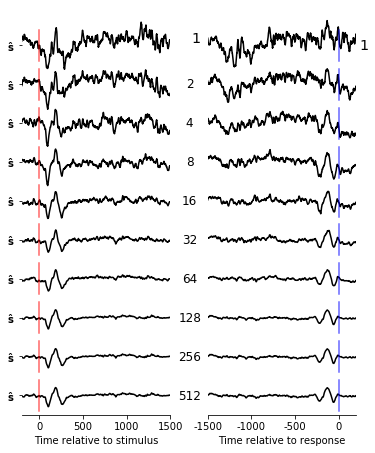

In [6]:
ymax = 3
fig, axs = plt.subplots(10, 2, sharex=False, sharey=False, figsize=(5, 6))
for i, n in enumerate([1, 2, 4, 8, 16, 32, 64, 128, 256, 512]):
    axs[i, 0].plot(np.mean(stim_samples[:n+1], 0), 'k-')
    axs[i, 0].plot([baseline, baseline], [-ymax*0.4, ymax*0.4], 'r-', alpha=0.6)
    axs[i, 0].set_xticks([])
    # axs[i, 0].set_xticks(np.arange(baseline, np.shape(stim_samples)[1]+1, 500))
    # axs[i, 0].set_xticklabels([])
    # axs[0].set_ylabel('Voltage')
    # axs[i, 0].set_ylabel(r'$\mathrm{\mu}V$')
    #axs[i, 0].set_ylabel(r'$\mathbf{\hat{s}_i}$')
    # axs[i, 0].text(
    #     0.06, 0.75, r'$\mathbf{\hat{s}_i}$', horizontalalignment='center',
    #     verticalalignment='center', transform=axs[i, 0].transAxes,
    #     size='large')
    axs[i, 1].plot(np.mean(resp_samples[:n+1], 0), 'k-')
    axs[i, 1].plot([datasamples, datasamples], [-ymax*0.4, ymax*0.4],
                   'b-', alpha=0.6)
    # axs[i, 1].set_xticks(np.arange(0, np.shape(stim_samples)[1]+1, 500))
    axs[i, 1].set_xticks([])
    axs[i, 1].set_xticklabels([])
    axs[i, 0].set_ylim((-ymax, ymax))
    axs[i, 1].set_ylim((-ymax, ymax))
    axs[i, 0].set_yticks([0])
    # axs[i, 1].set_yticks([0])
    axs[i, 1].set_yticks([])
    # axs[i, 0].set_yticklabels([r'$\mathbf{\hat{s}}('+str(n)+')$'])
    axs[i, 0].set_yticklabels([r'$\mathbf{\hat{s}}$'])
    # axs[i, 0].set_yticklabels([r'$\frac{1}{'+str(n)+r'}\sum_{i=0}^{'+str(n)+r'}x_i$'])
    # axs[i, 1].set_yticklabels([])
    # axs[i, 1].text(
    #     0.06, 0.75, r'$\mathbf{\hat{s}_i}$', horizontalalignment='center',
    #     verticalalignment='center', transform=axs[i, 1].transAxes,
    #    size='large')
    axs[i, 1].set_ylabel(n, rotation=0, size='large',
                         verticalalignment='center', labelpad=18)
    # axs[i, 1].text(1.12, 0.5, n, horizontalalignment='center',
    #               verticalalignment='center',
    #               transform=axs[i, 1].transAxes, size='large')
    axs[i, 0].set_frame_on(False)
    axs[i, 1].set_frame_on(False)
    axs[i, 0].set_xlim((0, datasamples+baseline))
    axs[i, 1].set_xlim((0, datasamples+baseline))
#axs[i, 0].set_xlabel('Time (ms) relative to stimulus')
#axs[i, 1].set_xlabel('Time (ms) relative to response')
axs[i, 0].set_xticklabels(np.arange(
    baseline, np.shape(stim_samples)[1]+1, 500)-baseline)
axs[i, 1].set_xticklabels(np.arange(
    -np.shape(stim_samples)[1]+baseline, 1, 500))
# fig.savefig('../figs/erp/sim_erp.pdf')
# axs[0, 1].text(1.12, 0.9, 'n', horizontalalignment='center',
#                verticalalignment='center',
#                transform=axs[0, 1].transAxes, size='xx-large')
# axs[i, 1].text(1.12, -0.25, 'n', horizontalalignment='center',
#                verticalalignment='center',
#                transform=axs[i, 1].transAxes, size='large')
ax_stim = axs[i, 0].twiny()
ax_stim.set_frame_on(True)
ax_stim.patch.set_visible(False)
for sp in ax_stim.spines.values():
    sp.set_visible(False)
ax_stim.spines["bottom"].set_visible(True)
ax_stim.xaxis.set_ticks_position("bottom")
ax_stim.xaxis.set_label_position("bottom")
ax_stim.set_xlabel('Time relative to stimulus')
ax_stim.set_xticks(np.arange(baseline, np.shape(stim_samples)[1]+1, 500))
ax_stim.set_xticklabels(
    np.arange(baseline, np.shape(stim_samples)[1]+1, 500)-baseline)
ax_stim.spines["bottom"].set_position(("axes", 0.25))
ax_stim.set_xlim((0, datasamples+baseline))

ax_resp = axs[i, 1].twiny()
ax_resp.set_frame_on(True)
ax_resp.patch.set_visible(False)
#for sp in ax_resp.spines.itervalues():
for sp in ax_resp.spines.values():
    sp.set_visible(False)
ax_resp.spines["bottom"].set_visible(True)
ax_resp.xaxis.set_ticks_position("bottom")
ax_resp.xaxis.set_label_position("bottom")
ax_resp.set_xlabel('Time relative to response')
ax_resp.set_xticks(np.arange(0, np.shape(stim_samples)[1]+1, 500))
ax_resp.set_xticklabels(np.arange(-np.shape(stim_samples)[1]+baseline, 1, 500))
ax_resp.spines["bottom"].set_position(("axes", 0.25))
ax_resp.set_xlim((0, datasamples+baseline))
fig.subplots_adjust(0.05, 0.03, 0.98, 1.02, 0.25, -0.5)
axs[0, 1].set_ylabel('1', rotation=0, size='x-large', verticalalignment='bottom', labelpad=12)

axs[0, 1].text(1.05, 0.5, '1', horizontalalignment='center',
        verticalalignment='center', transform=axs[0, 1].transAxes, size='x-large')
plt.show()


### Assignment 3: Event Related Potentials

In this assignment you will learn to carry out basic time-series analyses of electroencephalographic
(EEG) data. Specifically, you will measure event-related potentials (ERPs) associated with item
encoding events in a free recall experiment. For background on the ERP method please review
Chapter 3 of EHM.

You will be working with data from a single electrode 75 (Oz) from all subjects who have
data from experiment ltpFR2. You will analyze the time series of data surrounding each word
presentation, from -200 ms prior to word onset until 1,000 ms after word onset.

1. Plot the ERPs for recalled and not recalled items and add spearte 95% confidence bands around each ERP. Do the confidence bands exclude zero at any points? Which ones? Are there points where they do not overlap? What hypothesis is being tested by these confidence intervals?
2. For each subject, compute the difference between the two ERPs and average the difference ERPs across subjects. Now compute the 95% confidence band around the difference waveform. Does this exclude zero at any points? Do these results match those from the previous analysis? If not, explain the difference in the inference one can make from these confidence bands.
3. Compute an across-subject paired t-test (scipy.stats.ttest_rel), comparing the voltage of recalled and not recalled items at each time point. Use a horizontal bar to indicate which time points exceed the criterion of p < 0.05 without correcting for multiple comparisons. How do these results match up with those in the previous two exercises?
4. Recompute the statistical significance of the difference between ERPs using the false-discovery rate method. Indicate the points with p < 0.05 using a bar of another color shifted above or below the first bar. Comment on the difference between the two methods. Which is more conservative and why?

In [77]:
# First, our import statements.
import pandas as pd
import numpy as np

# The CMLLoad class is your gateway to the experimental data, including channels, events, and eeg data.
from CMLLoad import CMLLoad

# We need to tell CMLLoad what directory contains the experimental data files.
# Point this to where they are on your system.
load = CMLLoad('./CMLExamples')

df = load.Index()

In [111]:
df_exp = df[df['experiment'] == 'ltpFR2']
subjects = df_exp['subject'].unique()

In [159]:
t_buffer = 200
t_length = 1200
num_bins = t_length // 2

num_subjects = len(subjects)
erps = np.zeros((2, num_subjects, num_bins), dtype=np.float)
erp_count = np.zeros((2, num_subjects), dtype=np.uint)

In [198]:
for idx_subj in range(num_subjects):
    df_subj = df_exp[df_exp['subject'] == subjects[idx_subj]]
    num_sessions = len(df_subj)
    
    subj_erps = np.zeros((2, num_sessions, num_bins), dtype=np.float)
    subj_count = np.zeros((2, num_sessions), dtype=np.uint)
    for idx_session in range(num_sessions):
        locator = df_subj.iloc[idx_session]
        eeg, sr, channels = load.LoadEEG(locator, -t_buffer, t_length)
        evs = load.Load(locator, 'events')
        word_evs = evs[(evs['type'] == 'WORD') & (evs['trial'] > 0)]
        
        ch_eeg = np.copy(eeg[:, 74])
        ch_eeg -= ch_eeg[:, :t_buffer].mean(axis=1, keepdims=True)
        for is_recalled in range(2):
            rec_eeg = ch_eeg[word_evs[word_evs['recalled'] == is_recalled].index]
            rec_eeg = rec_eeg[~np.any(np.isnan(rec_eeg), axis=1)]
            if rec_eeg.shape[0] == 0:
                continue
            subj_erps[is_recalled, idx_session] = rec_eeg.mean(axis=0)
            subj_count[is_recalled, idx_session] = rec_eeg.shape[0]

    for is_recalled in range(2):
        erps[is_recalled, idx_subj] = np.average(subj_erps[is_recalled], axis=0, weights=subj_count[is_recalled])
        erp_count[is_recalled, idx_subj] = sum(subj_count[is_recalled])

In [244]:
weights = np.broadcast_to(erp_count[:, :, np.newaxis], (*erp_count.shape, 600))
erp_mean = np.average(erps, axis=1, weights=weights)
erp_std = np.sqrt(np.average((erps - erp_mean[:, np.newaxis, :])**2, axis=1, weights=weights))

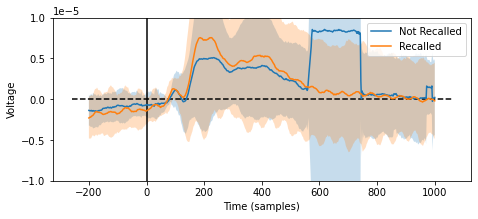

In [245]:
import matplotlib.pyplot as plt
import scipy.stats

xtime = np.linspace(-200, 1000, erp_mean.shape[1])
plt.figure(figsize=(7.5, 3))
ax = plt.subplot(111)
for erp, std in zip(erp_mean, erp_std):
    plt.plot(xtime, erp)
    plt.fill_between(xtime, erp-2*std, erp+2*std, alpha=0.25)
ax.set_ylim(-1e-5, 1e-5)
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('Voltage')
plt.legend(['Not Recalled', 'Recalled'])
plt.show()

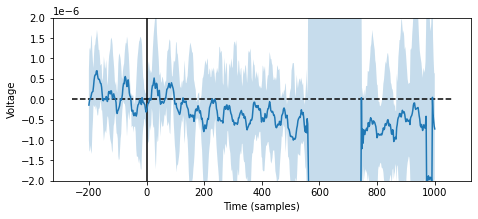

In [246]:
erp_diffs = np.diff(erps, axis=0)[0]
diff_mean, diff_std = erp_diffs.mean(axis=0), erp_diffs.std(axis=0)

xtime = np.linspace(-200, 1000, len(erp_diff))
plt.figure(figsize=(7.5, 3))
ax = plt.subplot(111)
plt.plot(xtime, diff_mean)
plt.fill_between(xtime, diff_mean - 2*diff_std, diff_mean + 2*diff_std, alpha=0.25)
ax.set_ylim(-2e-6, 2e-6)
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('Voltage')
# plt.legend(['Not Recalled', 'Recalled'])
plt.show()

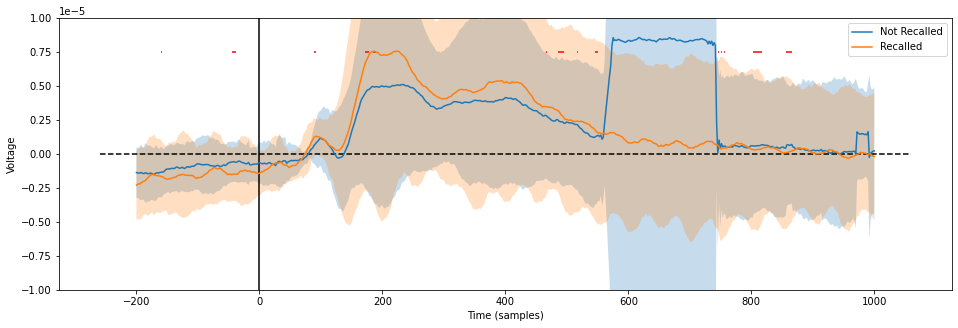

In [259]:
from scipy import stats
import matplotlib.pyplot as plt

xtime = np.linspace(-t_buffer, t_length - t_buffer, erp_mean.shape[1])
plt.figure(figsize=(16, 5))
ax = plt.subplot(111)
for erp, std in zip(erp_mean, erp_std):
    plt.plot(xtime, erp)
    plt.fill_between(xtime, erp-2*std, erp+2*std, alpha=0.25)

t, p = stats.ttest_rel(erps[0], erps[1], axis=0)
significant = 2*np.where(p < 0.05)[0] - t_buffer
plt.hlines(y=[0.75e-5] * len(significant), xmin=significant, xmax=significant + 2, color='r')

ax.set_ylim(-1e-5, 1e-5)
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('Voltage')
plt.legend(['Not Recalled', 'Recalled'])
plt.show()